In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25)
matplotlib.rc('axes',labelsize=25) 
from astropy.table import Table
import os
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/Published_Work/Base_Runs/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data():
    '''Reads in the Yu et al. 2018 data'''
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

In [3]:
from scipy.optimize import curve_fit
def f(x, A, B):
    return A*x + B

def get_slopes(mlsn, cnc, crc):
    for ml in mls:
        print(ml)
        knc = read_paramdict(ml+'_'+cnc, sort='astero')
        krc = read_paramdict(ml+'_'+crc, sort='astero')
        popt, pcov = curve_fit(f, knc[ml+'_'+cnc].astype(float).values, knc.mu.values, sigma=knc.mu_std.values)
        print('mu(no Correction) = '+str(np.round(popt[0],5))+'x + '+str(np.round(popt[1],5)))

        popt, pcov = curve_fit(f, krc[ml+'_'+crc].astype(float).values, krc.mu.values, sigma=krc.mu_std.values)
        print('mu(RC) = '+str(np.round(popt[0],5))+'x + '+str(np.round(popt[1],5)))
        print('\n')
        
        print('mu(RC)(0.0) = '+str(np.round(krc.mu[krc[ml+'_'+crc]=='0.0'].values[0],5)) + ' pm '+str(np.round(krc.mu_std[krc[ml+'_'+crc]=='0.0'].values[0],5)))
        print('\n')
        
        print('sigma(RC)(0.0) = '+str(np.round(krc.sigma[krc[ml+'_'+crc]=='0.0'].values[0],5)) + ' pm '+str(np.round(krc.sigma_std[krc[ml+'_'+crc]=='0.0'].values[0],5)))
        print('\n')
        
        print('mu(NoCorr)(0.0) = '+str(np.round(knc.mu[knc[ml+'_'+cnc]=='0.0'].values[0],5)) + ' pm '+str(np.round(knc.mu_std[knc[ml+'_'+cnc]=='0.0'].values[0],5)))
        print('\n')
        
        print('sigma(NoCorr)(0.0) = '+str(np.round(knc.sigma[knc[ml+'_'+cnc]=='0.0'].values[0],5)) + ' pm '+str(np.round(knc.sigma_std[knc[ml+'_'+cnc]=='0.0'].values[0],5)))
        print('\n')

In [4]:
def read_paramdict(majorlabel, minorlabel='', sort='astero'):
    '''Reads in results for either:
        -A full run series (majorlabel) where the minorlabel is included as a
            column in the output.
        -A single run (majorlabel and minorlabel).

        Returns a pandas dataframe.
    '''
    loc = __outdir__+majorlabel+'/'

    if minorlabel != '':
        globlist = glob.glob(loc+sort+'_'+str(float(minorlabel))+'_*pars*.csv')
    else:
        globlist = glob.glob(loc+sort+'*_*pars*.csv')

    minorlabels = [os.path.basename(globloc).split('_')[1] for globloc in globlist]
    if sort == 'gaia':
        ccdlabels = [os.path.basename(globloc).split('_')[-2] for globloc in globlist]
        
    df = pd.DataFrame()
    for n, globloc in enumerate(globlist):
        sdf = pd.read_csv(globloc, index_col = 0)
        if minorlabels[n] != 'pars.csv':
            sdf[majorlabel] = minorlabels[n]
            if sort == 'gaia':
                sdf['ccdlabel'] = ccdlabels[n]
        df = df.append(sdf)

    return df.sort_values(by=majorlabel)

In [5]:
def violinplot(mls, kind, bands, cnc, crc, save=''):
    music1 = read_music(mls[0], kind, bands[0], cnc, crc)
    music2 = read_music(mls[1], kind, bands[1], cnc, crc)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    sns.violinplot(music1.tempscales.astype(int).values, music1.chains.values, hue=music1.ncrc.values,
                        palette='Set2',split=True, inner='quartile', ax = ax1)

    sns.violinplot(music2.tempscales.astype(int).values, music2.chains.values, hue=music2.ncrc.values,
                    palette='Set2',split=True, inner='quartile', ax = ax2)
    ax1.grid()
    ax1.set_axisbelow(True)
    ax2.grid()
    ax2.set_axisbelow(True)  
    ax1.set(xlabel=r'Perturbation to Temperature $\Delta T_{\rm eff}$ (K)', ylabel='Position of RC in given band (mag)')
    ax1.set_title(r'$K$ band',fontsize=25)
    ax2.set(xlabel=r'Perturbation to Temperature $\Delta T_{\rm eff}$ (K)')#, ylabel=r'Position of RC in $\emph{Gaia}$ G band (mag)')
    ax2.set_title(r'$Gaia$ $G$ band',fontsize=25)    
    plt.setp(ax1.get_legend().get_texts(), fontsize='25')
    plt.setp(ax2.get_legend().get_texts(), fontsize='25')
    fig.tight_layout()
    
    if save is not '':
        plt.savefig(save)
    plt.show()

def read_music(ml, kind, band, cnc, crc):
    chains = np.array([])
    tempscales = np.array([])
    ncrc = np.array([])

    for ts in np.arange(-50.,60.,10.):
        temp = str(ts)
        #Add NC chains & labels
        chain = np.genfromtxt(glob.glob(__outdir__+ml+'_'+cnc+'/'+kind+'_'+temp+'_chains.txt')[0])[0]
        chains = np.append(chains, chain)
        tempscales = np.append(tempscales, np.ones(len(chain))*ts)
        ncrc = np.append(ncrc, ['No Correction']*len(chain))

        #Add RC chains & labels
        chain = np.genfromtxt(glob.glob(__outdir__+ml+'_'+crc+'/'+kind+'_'+temp+'_chains.txt')[0])[0]
        chains = np.append(chains, chain)
        tempscales = np.append(tempscales, np.ones(len(chain))*ts)
        ncrc = np.append(ncrc, ['Clump Corrected']*len(chain))

    music = pd.DataFrame()
    music['chains'] = chains
    music['tempscales'] = tempscales
    music['ncrc'] = ncrc
    return music

## Plot violinplots and uncover gradients

/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


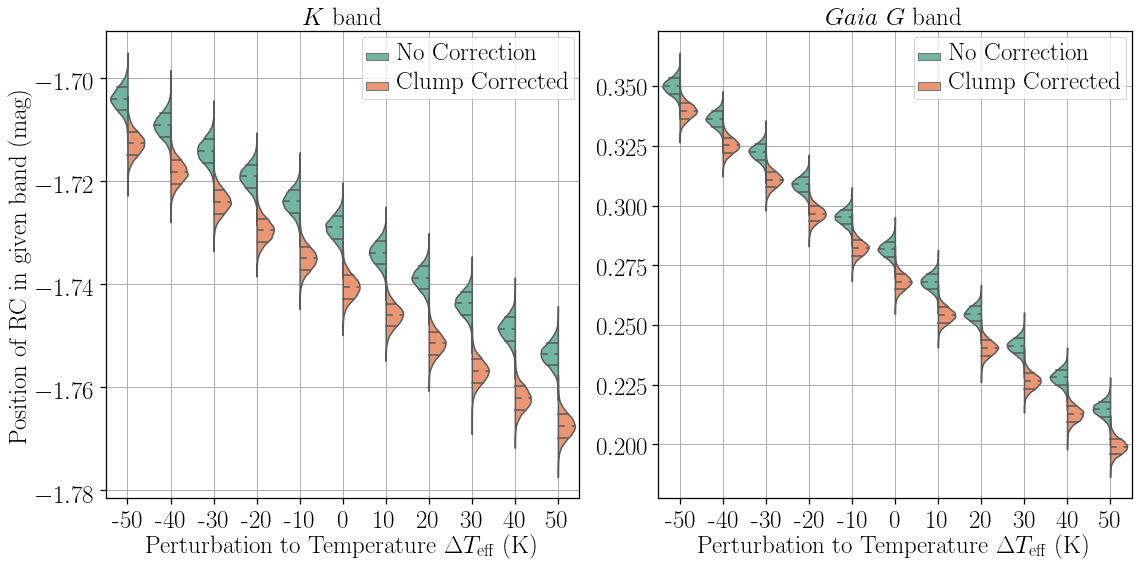

In [6]:
mls = ['K_tempscale', 'GAIA_tempscale']
kind = 'astero'
bands = ['K', 'GAIA']
cnc = 'noCorrection'
crc = 'Clump'
violinplot(mls, kind, bands, cnc, crc, 
    save='/home/oliver/Dropbox/Papers/Hall+18/Figures/yu_posteriors.pdf')
# get_slopes(mls, cnc, crc)

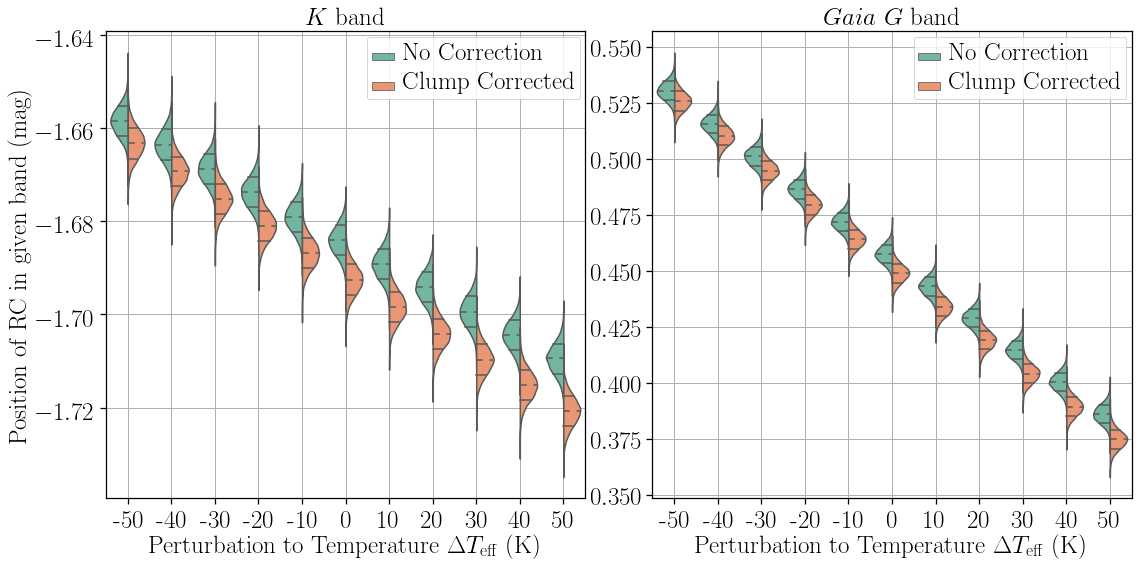

In [7]:
mls = ['APOKASC_K_tempscale', 'APOKASC_GAIA_tempscale']
kind = 'astero'
bands = ['K', 'GAIA']
cnc = 'noCorrection'
crc = 'Clump'
violinplot(mls, kind, bands, cnc, crc, 
    save='/home/oliver/Dropbox/Papers/Hall+18/Figures/apokasc2_posteriors.pdf')
# get_slopes(mls, cnc, crc)

# APOKASC-2 differences

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from mpl_toolkits.axes_grid1.colorbar import colorbar
import matplotlib.gridspec as gridspec

In [9]:
yu = pd.read_csv(__datdir__+'rcxyu18.csv')
apo = pd.read_csv(__datdir__+'rcxyuxapokasc2.csv')

In [10]:
import os
import sys
sys.path.append(os.path.expanduser('~')+'/PhD/Hacks_and_Mocks/asfgrid/')
import asfgrid
from omnitool import scalings
from omnitool.literature_values import Msol, Rsol
def get_fdnu(df):
    asf = asfgrid.Seism()
    evstate = np.ones(len(df))*2
    logz = np.log10(df.Z.values)
    teff = df.Teff.values
    dnu = df.dnu.values
    numax = df.numax.values

    mass, radius = asf.get_mass_radius(evstate, logz, teff, dnu, numax)
    logg = asf.mr2logg(mass, radius)
    fdnu = asf._get_fdnu(evstate, logz, teff, mass, logg, fill_value='nearest')

    return fdnu

('outside interp range', 22, ' out of ', 1637)
('outside interp range', 94, ' out of ', 1637)
You have passed corrections to the Delta Nu scaling relation


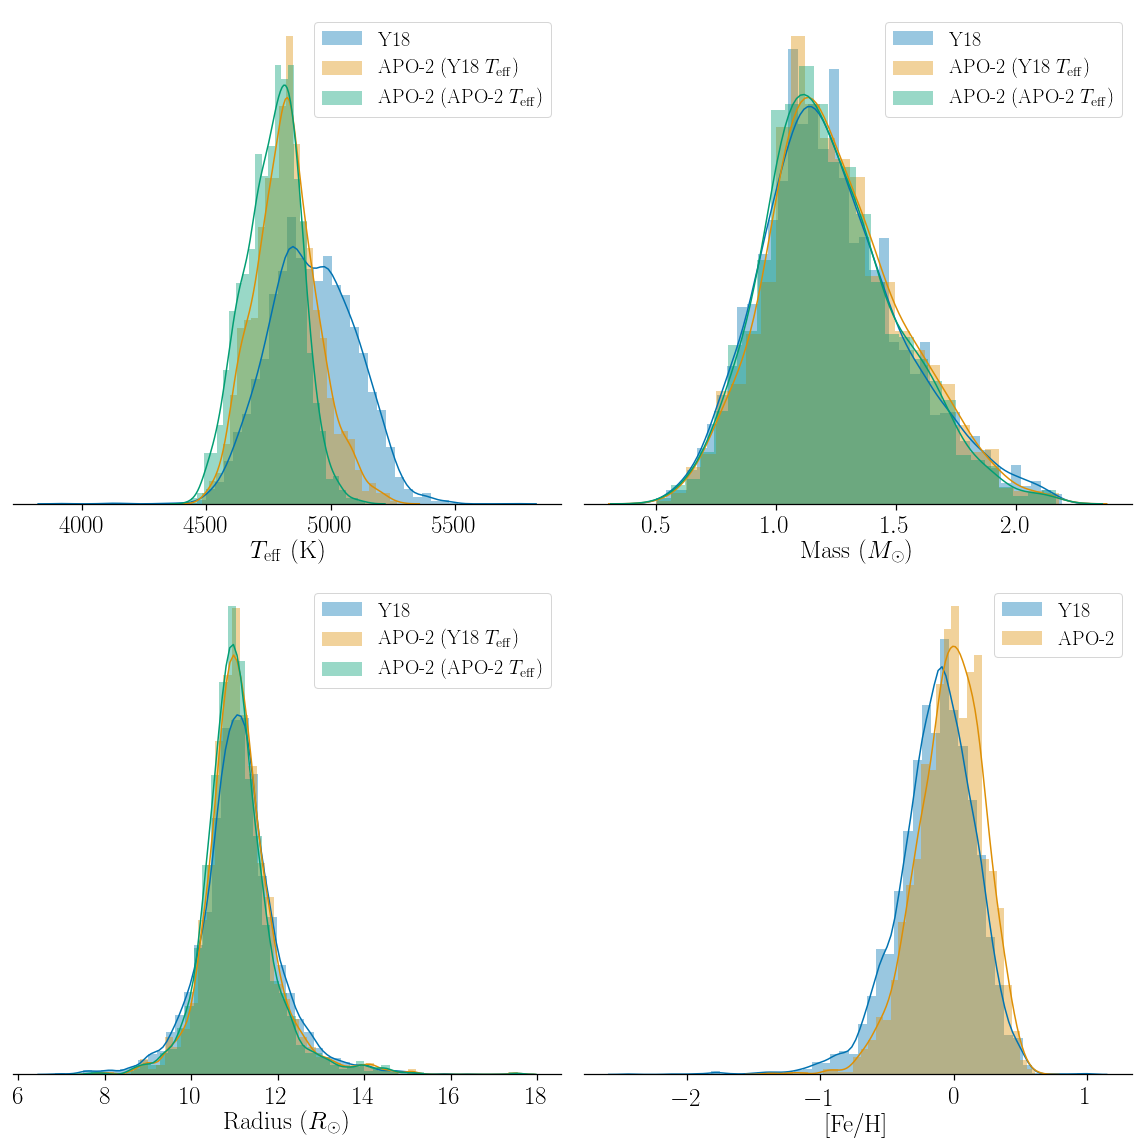

In [12]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 16))
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)


sns.distplot(yu.Teff, label='Y18', ax=ax1)
sns.distplot(apo.Yu_Teff, label=r'APO-2 (Y18 $T_{\rm eff})$', ax=ax1)
sns.distplot(apo.Teff, label=r'APO-2 (APO-2 $T_{\rm eff})$', ax=ax1)

sc = scalings(apo.numax, apo.dnu, apo.Teff,\
                      _numax_err = apo.numax_err, _dnu_err = apo.dnu_err,\
                      _Teff_err = apo.Teff_err)
sc.give_corrections(fdnu = get_fdnu(apo))

sns.distplot(yu.M_Clump, label='Y18', ax=ax2)
sns.distplot(apo.M_Clump, label=r'APO-2 (Y18 $T_{\rm eff})$', ax=ax2)
sns.distplot(sc.get_mass()/Msol, label=r'APO-2 (APO-2 $T_{\rm eff})$', ax=ax2)


sns.distplot(yu.R_Clump, label='Y18', ax=ax3)
sns.distplot(apo.R_Clump, label=r'APO-2 (Y18 $T_{\rm eff}$)', ax=ax3)
sns.distplot(sc.get_radius()/Rsol, label=r'APO-2 (APO-2 $T_{\rm eff})$', ax=ax3)

sns.distplot(yu['[Fe/H]'], label='Y18', ax=ax4)
sns.distplot(apo['[Fe/H]'], label=r'APO-2', ax=ax4)

ax1.set_xlabel(r'$T_{\rm eff}$ (K)')
ax2.set_xlabel(r'Mass ($M_\odot$)')
ax3.set_xlabel(r'Radius ($R_\odot$)')
ax4.set_xlabel(r'[Fe/H]')

ax1.legend(fontsize=20, loc='upper right')
ax2.legend(fontsize=20, loc='upper right')
ax3.legend(fontsize=20, loc='upper right')
ax4.legend(fontsize=20, loc='upper right')

fig.tight_layout()
plt.savefig('/home/oliver/Dropbox/Papers/Hall+18/Figures/apokasc-2-dists.pdf')
plt.show()